## Create Dataset for filtering: Idea Startup

In [ ]:
!pip3 install requests Pillow beautifulsoup4

In [ ]:
import requests, os
from bs4 import BeautifulSoup

# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

response = requests.get("https://ideasai.com/data-startup-ideas")
soup = BeautifulSoup(response.text, "html.parser")

ideas = soup.findAll('h3', class_='idea')
idea_descriptions = [desc.text for desc in ideas]
print(idea_descriptions, len(idea_descriptions))

votes = soup.findAll('span', class_='votes')
voting = [v.text for v in votes]
print(voting)

print (len(voting), len(idea_descriptions))

import csv

file_path='data/valid_ideas.csv'
print(os.getcwd())

  # Try to open non-existing file to write data
with open(file_path, "x+") as file:
  # Read the contents of the file
  for idx in range(len(voting)):
    desc = idea_descriptions[idx].replace('"', '')
    vote = voting[idx].replace(',', '')
    sen = ';'.join([desc, '1', vote, '\n'])
    file.write(sen)

In [ ]:
import requests, json
from bs4 import BeautifulSoup

# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

response = requests.get("https://randomwordgenerator.com/json/sentences.json")
type(response.text)
data = json.loads(response.text)
print(data["data"])
sentences = data["data"]

import csv

with open('data/invalid-sentences.csv', 'x+', newline='') as file:
  writer = csv.writer(file)
  
  for idx in range(len(sentences)):
    writer.writerow([sentences[idx]["sentence"], 0])
    

In [ ]:
import requests, json
from bs4 import BeautifulSoup

# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

response = requests.get("https://www.randomsentencegen.com/sentence-with-startup")
soup = BeautifulSoup(response.text, "html.parser")

ideas = soup.findAll('tr', class_='item')
idea_descriptions = [desc.text for desc in ideas]
print(idea_descriptions, len(idea_descriptions))

import csv

with open('data/invalid-sentences.csv', 'x+', newline='') as file:
  writer = csv.writer(file)
  
  for idx in range(len(sentences)):
    writer.writerow([sentences[idx]["sentence"], 0])
    

## Filtering by LSTM

### Import

In [ ]:
import pandas as pd

invalid_0 = pd.read_csv("data/invalid_sentences.csv", delimiter=';')
invalid_1 = pd.read_csv("data/random_str.csv", delimiter=',')
semantic = pd.read_csv("data/valid_ideas.csv", delimiter=';', usecols=['sentence', 'spam'])

invalid_0.head()
invalid_1.head()
semantic.head()

frames = [invalid_0, semantic, invalid_1]
 
df = pd.concat(frames)

df.head()

### Sequence Model

Install Tensorflow on M1: https://medium.com/@sorenlind/tensorflow-with-gpu-support-on-apple-silicon-mac-with-homebrew-and-without-conda-miniforge-915b2f15425b

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip3 install -U tensorflow-macos tensorflow-metal
!pip3 install plotlib tf-models-official

In [ ]:
!pip3 show tensorflow
!pip3 install tensorflow --user

In [ ]:
import os
import shutil

import tensorflow as tf

tf.config.list_physical_device("GPU")
# from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [ ]:
!pip3 install sklearn

In [ ]:
from sklearn.model_selection import train_test_split

#Create test and train samples from one dataframe with pandas?
train_data, test_data = train_test_split(df, test_size=0.3)

In [ ]:
train_list = train_data.values.tolist()
print(train_list)

## Build Vocabulary - TextVectorization

In [ ]:
from tensorflow.keras.layers import TextVectorization


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)


# Now that the vectorize_layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
# Let's call `adapt`:
train_without_label = train_data.loc[:, df.columns == 'sentence']
train_dataset = tf.data.Dataset.from_tensor_slices(train_without_label.to_dict(orient="list"))
list_data = train_without_label.values.tolist()

# Adapt with Dataframe
# vectorize_layer.adapt(train_without_label, batch_size=64)

# Adapt with list
vectorize_layer.adapt(list_data, batch_size=64)
vectorize_layer.get_vocabulary()


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([[1,2], [2,3], [3,4]])
dataset = dataset.map(lambda x: x*2)
list(dataset.as_numpy_iterator())

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data.to_dict(orient="list"))
map_dataset = train_dataset.map(lambda x: (vectorize_layer(x['sentence']), x['spam']))

# Train Dataset with dictionary -> get the tensor dimen
# for ele in train_dataset:
#     print(ele)
#     print(ele['sentence'].numpy())
#     print(ele['spam'].numpy())

for ele in map_dataset:
    print(ele)

In [ ]:
def vectorize_text(text, label):
  label = tf.expand_dims(label, -1)
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

def mapping_vocab(dataframe, callable):
  training_ds = tf.data.Dataset.from_tensor_slices(dataframe.to_dict(orient="list"))

  text_batch, label_batch = next(iter(training_ds))
  first_review, first_label = text_batch[0], label_batch[0]
  # print("Column Name", text_batch, label_batch)

  map_dataset = training_ds.map(lambda x: callable(x['sentence'], x['spam']))
  # print(map_dataset.element_spec)
  return map_dataset

# Vectorize the data.
train_ds = mapping_vocab(train_data, vectorize_text)
val_ds = mapping_vocab(train_data, vectorize_text)
test_ds = mapping_vocab(test_data, vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

for ele in train_ds:
  print(ele)

In [ ]:
from tensorflow.keras import layers

# https://www.tensorflow.org/tutorials/keras/text_classification

# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 3

# Fit the model using the train and test datasets.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

### Evaluation

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export Model

When using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, None) with rank=2 <br>

Have to reshape `TextVectorization` but its too difficult

In [ ]:
import numpy as np

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

flat_data = np.array([list(train_data.values)]).flatten()
print(flat_data)
test_export_dataset = tf.data.Dataset.from_tensor_slices(flat_data)

# Test it with `test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test_export_dataset)
print(accuracy)

In [ ]:
for x in train_ds.take(1):
  print(x[0].numpy())

  model.predict(train_ds)

## EMBEDDING LAYER

In [ ]:
!pip3 install pandas numpy seaborn matplotlib scikit-learn keras

In [ ]:
!pip3 install tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
# tf.keras.optimizers.legacy.RMSprop
from keras.optimizers.legacy import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [67]:
import pandas as pd

invalid_0 = pd.read_csv("data/invalid_sentences.csv", delimiter=';')
invalid_1 = pd.read_csv("data/random_str.csv", delimiter=',')
semantic = pd.read_csv("data/valid_ideas.csv", delimiter=';', usecols=['sentence', 'spam'])

invalid_0.head()
invalid_1.head()
semantic.head()

frames = [invalid_0, semantic, invalid_1]
 
df = pd.concat(frames)

df.head()

,sentence,spam
0,The quick brown fox jumps over the lazy dog.,0
1,My Mum tries to be cool by saying that she lik...,0
2,A purple pig and a green donkey flew a kite in...,0
3,Last Friday I saw a spotted striped blue worm ...,0
4,A song can make or ruin a person’s day if they...,0


Text(0.5, 1.0, 'Number of ham (1) and spam (0) ideas')

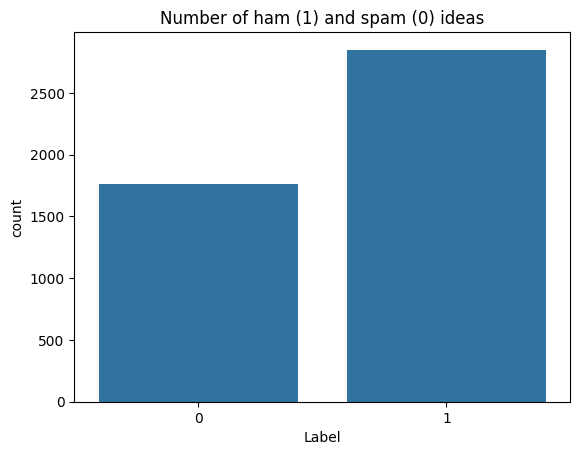

In [68]:
sns.countplot(df, x="spam")
plt.xlabel('Label')
plt.title('Number of ham (1) and spam (0) ideas')

In [69]:
X = df.sentence
Y = df.spam
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [70]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [71]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [72]:
def RNN():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [73]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [74]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])



Epoch 1/5
25/25 [==============================] - 5s 152ms/step - loss: 0.3238 - accuracy: 0.8778 - val_loss: 0.0920 - val_accuracy: 0.9885
Epoch 2/5
25/25 [==============================] - 3s 121ms/step - loss: 0.0543 - accuracy: 0.9844 - val_loss: 0.0517 - val_accuracy: 0.9936
Epoch 3/5
25/25 [==============================] - 3s 119ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0404 - val_accuracy: 0.9962
Epoch 4/5
25/25 [==============================] - 3s 118ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0407 - val_accuracy: 0.9962


In [75]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [76]:
accr = model.evaluate(test_sequences_matrix,Y_test)

22/22 [==============================] - 0s 14ms/step - loss: 0.0256 - accuracy: 0.9928


In [77]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.026
  Accuracy: 0.993


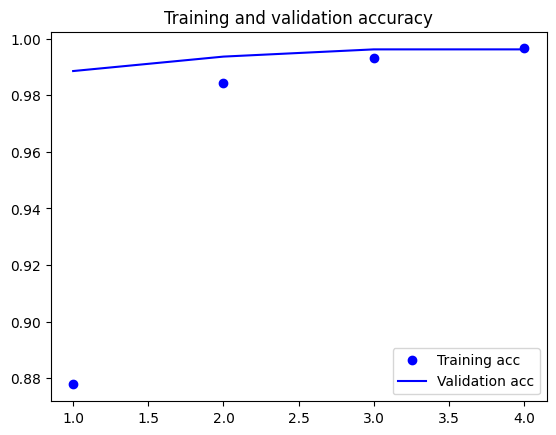

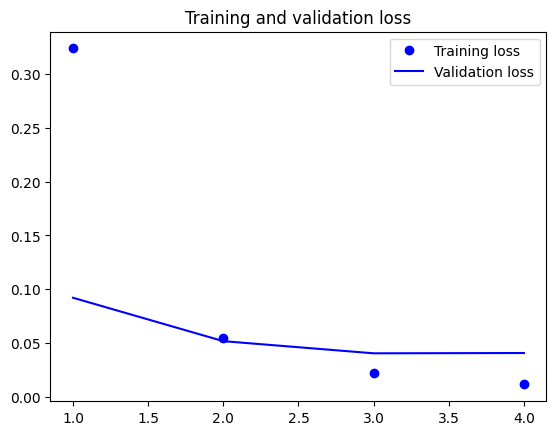

In [78]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [79]:
word_idx = 10
prediction = model.predict(test_sequences_matrix[word_idx:word_idx+10])
print(prediction, X_test[word_idx:word_idx+10])

1/1 [==============================] - 0s 297ms/step
[[1.        ]
 [0.00263656]
 [1.        ]
 [1.        ]
 [0.00106954]
 [1.        ]
 [0.9999986 ]
 [0.00878514]
 [1.        ]
 [1.        ]] 1959    A visual calendar that lets you view data from...
178     He stepped gingerly onto the bridge knowing th...
1091    A company that teaches employees how to ask fo...
368      A data platform that helps detect, prevent, a...
109     ftjricbxkxmpvzschfign mycxxtbflgqgyclfslknxpb ...
2068    A startup that monitors the health of your hom...
1906    A startup in the US that does “intelligence” f...
482     The clouds formed beautiful animals in the sky...
1614    Maintains and manages a database of resumes an...
2573    A data analytics platform for healthcare provi...
Name: sentence, dtype: object


In [80]:
def input(new_sentence, ai_model):
  new_sentence = new_sentence + "."
  test_sequences = tok.texts_to_sequences([new_sentence])
  test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
  prediction = ai_model.predict(test_sequences_matrix)
  label = "spam"
  if prediction > 0.5:
    label = "innovative idea"
  print(prediction, new_sentence)

In [81]:
input("Nghi is beautiful", model)
input("Nghi is building an AI app for tracking habit automatically that use voice-over to record your daily activities", model)
input("Origin recipes for this manificient coffee shop", model)
input("This is the new way to play guitar", model)
input("This is the new book", model)
input("This is the new AI model helping homework completion", model)
input("We are operating new AI model to auto complete homework", model)
input("Instagram is so popular that now everyone is using, scrolling til tired", model)

1/1 [==============================] - 0s 25ms/step
[[0.00132614]] Nghi is beautiful.
1/1 [==============================] - 0s 22ms/step
[[0.9999996]] Nghi is building an AI app for tracking habit automatically that use voice-over to record your daily activities.
1/1 [==============================] - 0s 22ms/step
[[0.01435913]] Origin recipes for this manificient coffee shop.
1/1 [==============================] - 0s 22ms/step
[[0.01081974]] This is the new way to play guitar.
1/1 [==============================] - 0s 22ms/step
[[0.00141158]] This is the new book.
1/1 [==============================] - 0s 26ms/step
[[0.13556604]] This is the new AI model helping homework completion.
1/1 [==============================] - 0s 32ms/step
[[0.03161694]] We are operating new AI model to auto complete homework.
1/1 [==============================] - 0s 28ms/step
[[0.02000524]] Instagram is so popular that now everyone is using, scrolling til tired.
